In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons

import torch
from torch import nn

#### Generate Sample Data

In [4]:


X, y = make_moons(256, noise=0.1)

data_dict = {'x0': X[:, 0], 'x1': X[:,1], 'y': y}

df = pd.DataFrame(data_dict)

In [5]:
df.to_csv('data/raw/sample_data.csv')

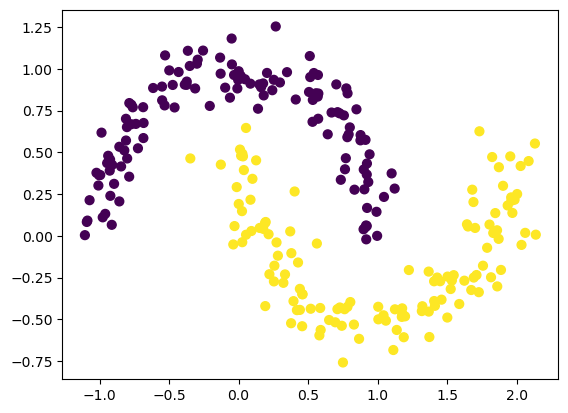

In [6]:
data = pd.read_csv('data/raw/sample_data.csv')

# Create 2D numpy array from x0 and x1 columns
X_orig = data[['x0', 'x1']].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data['y'].to_numpy()

plt.scatter(X_orig[:,0], X_orig[:,1], s = 40, c=y_orig)

#### Prepare Data for PyTorch

In [7]:
# Convert the 2D points to a float32 (why?) tensor
X = torch.tensor(X_orig, dtype = torch.float32)

# Convert labels to long integer tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)

In [8]:


class NaiveNet(nn.Module):

    def __init__(self):
        # super makes the (child) class inherit attributes from the nn module (ex: class Perishable(Product)): ... super(Perishable, self).__init__())
        super(NaiveNet, self).__init__()

        # the network is defined as a sequence of operations
        self.layers = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,2)
        )

    def forward(self, x):
        """
        Defines the forward pass
        """
        return self.layers(x)
    
    # predict not essential, but good practice
    def predict(self, x):

        output = self.forward(x)

        # why dim=1? and why argmax? the index at which the output is highest
        # because get the label (is that the arg?) with the highest score
        # dim = 1 because that's the class dimension (2 columns for two classes)
        # argmax because you want which column has the highest y-value (0th column - one class, 1st column - another class)
        return torch.argmax(output, dim = 1) 

    # also not essential, but good practice to include
    def train(self, X, y):
        pass





In [9]:
model = NaiveNet()
model

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [10]:
import random
random.seed(2025)

X_samples = X[:5]

X_samples

tensor([[-0.8962,  0.3114],
        [ 0.2670,  1.2544],
        [ 1.8709, -0.0183],
        [ 0.0534,  0.0064],
        [ 0.7271,  0.7337]])

In [11]:
random.randint(0,X.shape[0])

42

In [12]:
# output is not probabilities, but it's scores that reflect likelihood of labels, that's why getting the argmax
# gives you the predicted label
output = model.forward(X_samples)

# y_orig is just labels for classes (1 or 0). y_prediction is the predicted label
y_prediction = model.predict(X_samples)

In [13]:
output.max()

tensor(0.6305, grad_fn=<MaxBackward1>)

In [14]:
y_prediction

tensor([1, 1, 0, 1, 1])

### Train the neural network

Helper function for plotting decision boundary.

In [15]:
# @title Helper function to plot the decision boundary

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/

from pathlib import Path

def plot_decision_boundary(model, X, y, device):
  """
  Helper function to plot decision boundary

  Args:
    model: nn.module
      NaiveNet instance
    X: torch.tensor
      Input CIFAR10 data
    y: torch.tensor
      Class Labels/Targets
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing
  """
  # Transfer the data to the CPU
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Check if the frames folder exists and create it if needed
  frames_path = Path("frames")
  if not frames_path.exists():
    frames_path.mkdir()

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Predict the function value for the whole gid
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
  Z = model.predict(grid_points.to(device)).cpu().numpy()
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

Implement train function given training dataset X and corresponding labels y.

In [18]:
def train(model, X: torch.tensor, y: torch.tensor) -> float:
    """
    Training the neural network

    Args:
      X: input
      Y: labels/targets

    Returns:
      losses: Cross entropy loss
    """

    # cross entropy loss is the appropriate loss function for classification problems
    loss_function = nn.CrossEntropyLoss()

    # create an stochastic gradient descent optimizer
    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    epochs = 10000

    losses = []

    for iepoch in range(epochs):

        # logits is the unnormalized scores (output) of the network. To normalize use f.ex. a softmax function
        y_logits = model.forward(X)

        loss = loss_function(y_logits, y)

        # clear of previous gradients and compute new ones
        optimizer.zero_grad()
        loss.backward()

        # adapt the weights of the network
        optimizer.step()

        losses.append(loss.item())

        if iepoch % 1000 == 0:
            print(f'Epoch {iepoch} loss is {loss.item()}')

            plot_decision_boundary(model, X, y, 'cpu')

    return losses

Epoch 0 loss is 0.6863823533058167
Epoch 1000 loss is 0.2896518111228943
Epoch 2000 loss is 0.24789033830165863
Epoch 3000 loss is 0.2263699471950531
Epoch 4000 loss is 0.21070069074630737
Epoch 5000 loss is 0.1952042281627655
Epoch 6000 loss is 0.17843542993068695
Epoch 7000 loss is 0.16058479249477386
Epoch 8000 loss is 0.14253221452236176
Epoch 9000 loss is 0.125608891248703


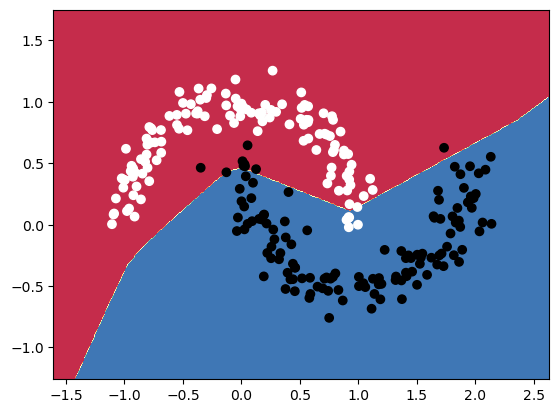

In [19]:
model = NaiveNet()
losses = train(model, X, y)